# Comparing `DirectCoordinateProjector` and `FourierSliceProjector`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tme import Structure

from mosaics.filters.exposure_filter import apply_cumulative_exposure_filter
from mosaics.reference_template.projector import DirectCoordinateProjector
from mosaics.reference_template.projector import FourierSliceProjector

In [2]:
pdb_path = "/Users/mgiammar/Documents/MOSAICS/docs/_static/parsed_6Q8Y.pdb"  # TODO: Remote or relative
mrc_path = "/Users/mgiammar/Documents/MOSAICS/data/lsu.mrc"  # TODO: Remote or relative

In [3]:
# Load the structure
structure = Structure.from_file(pdb_path)
display(structure)

# Center the structure by mass
mass_center = structure.center_of_mass()
print(f"Original mass center:\n\t{mass_center}")

structure = structure.rigid_transform(
    translation=-mass_center, rotation_matrix=np.eye(3)
)

mass_center = structure.center_of_mass()
print(f"New mass center:\n\t{mass_center}")

Structure object at 5365084752
Unique Chains: A-B-C-D-E-F-G-H-I-J-K-L-M-N-O-P-Q-R-S-T-U-V-W-X-Y-k-l-m-n-o-p-q-r-s-t-u-v-w, Atom Range: 1-123192 [N = 123149], Residue Range: 1-3396 [N = 3163]

Original mass center:
	[ -5.01248084 -22.12897313   1.63241817]
New mass center:
	[-3.44848005e-05  1.75404276e-04 -2.07310341e-05]


In [4]:
pixel_size = 0.95
projection_shape=(512, 512)

atom_coordinate = structure.atom_coordinate
atomic_identities = structure.element_symbol
b_factor = structure.temperature_factor

# Instantiate the objet to project the structure
direct_projector = DirectCoordinateProjector(
    pixel_size=pixel_size,
    projection_shape=projection_shape,
    atomic_coordinates=atom_coordinate,
    atomic_identities=atomic_identities,
    b_factors=b_factor,
)

In [5]:
fourier_projector = FourierSliceProjector.from_mrc(mrc_path)

## Compare the two projections


In [6]:
phi = np.deg2rad(0)
theta = np.deg2rad(0)
psi = np.deg2rad(0)

# Project the structure
fourier_projection_image = fourier_projector.get_real_space_projection(phi, theta, psi)
direct_projection_image = direct_projector.get_real_space_projection(phi, theta, psi)
direct_projection_image = apply_cumulative_exposure_filter(direct_projection_image, pixel_size, 0.0, 30.0).T

# Normalize the images to mean 0 and std 1
fourier_projection_image = (fourier_projection_image - fourier_projection_image.mean()) / fourier_projection_image.std()
direct_projection_image = (direct_projection_image - direct_projection_image.mean()) / direct_projection_image.std()

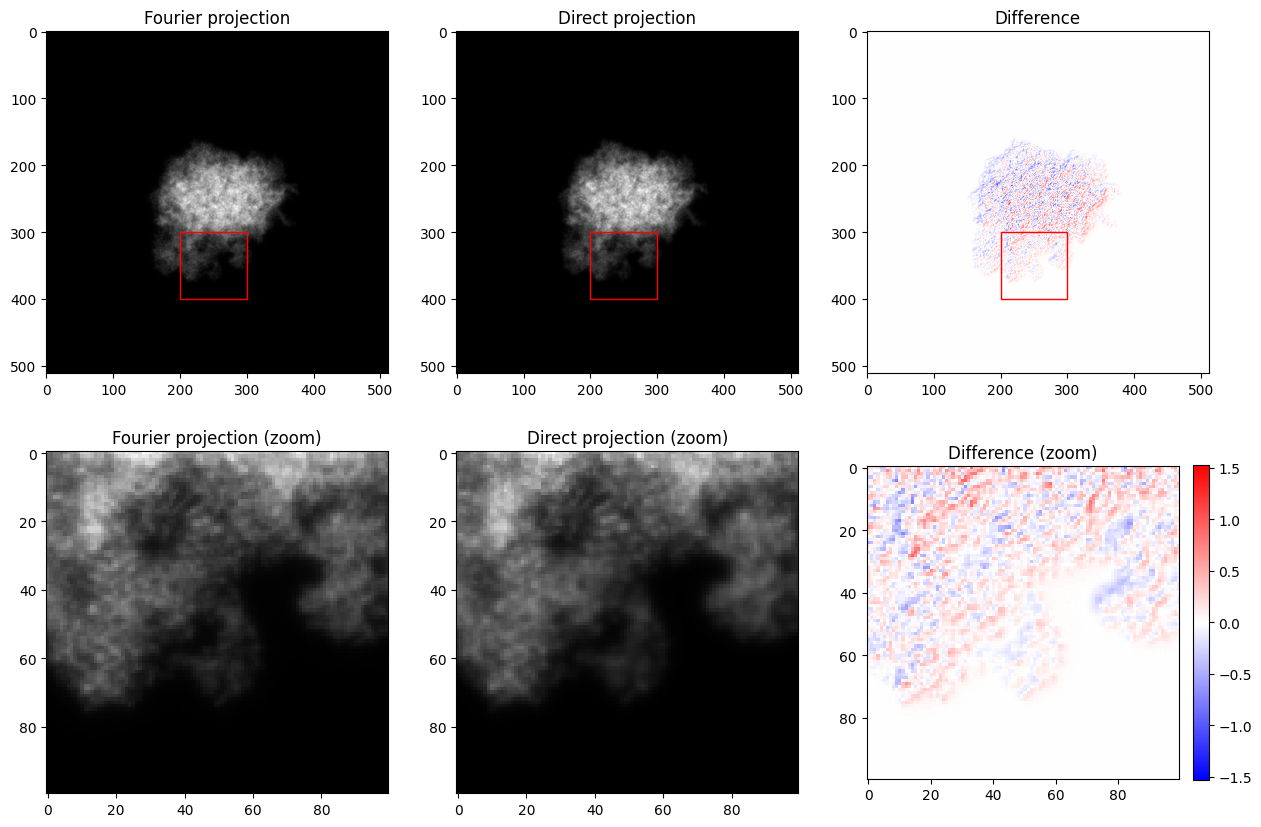

In [7]:
fix, ax = plt.subplots(2, 3, figsize=(15, 10))

region_of_interest = [(200, 300), (300, 400)]

ax[0, 0].imshow(fourier_projection_image, cmap="gray")
ax[0, 0].add_patch(patches.Rectangle(
    region_of_interest[0],
    region_of_interest[1][0] - region_of_interest[0][0],
    region_of_interest[1][1] - region_of_interest[0][1],
    edgecolor="r",
    facecolor="none")
)
ax[0, 0].set_title("Fourier projection")

ax[0, 1].imshow(direct_projection_image, cmap="gray")
ax[0, 1].add_patch(patches.Rectangle(
    region_of_interest[0],
    region_of_interest[1][0] - region_of_interest[0][0],
    region_of_interest[1][1] - region_of_interest[0][1],
    edgecolor="r",
    facecolor="none")
)
ax[0, 1].set_title("Direct projection")

difference = fourier_projection_image - direct_projection_image
max_diff = np.abs(difference).max()
ax[0, 2].imshow(difference, cmap="bwr", vmin=-max_diff, vmax=max_diff)
ax[0, 2].add_patch(patches.Rectangle(
    region_of_interest[0],
    region_of_interest[1][0] - region_of_interest[0][0],
    region_of_interest[1][1] - region_of_interest[0][1],
    edgecolor="r",
    facecolor="none")
)
ax[0, 2].set_title("Difference")


ax[1, 0].imshow(
    fourier_projection_image[
        region_of_interest[0][1]:region_of_interest[1][1],
        region_of_interest[0][0]:region_of_interest[1][0],
    ],
    cmap="gray"
)
ax[1, 0].set_title("Fourier projection (zoom)")

ax[1, 1].imshow(
    direct_projection_image[
        region_of_interest[0][1]:region_of_interest[1][1],
        region_of_interest[0][0]:region_of_interest[1][0],
    ],
    cmap="gray"
)
ax[1, 1].set_title("Direct projection (zoom)")

im12 = ax[1, 2].imshow(
    difference[
        region_of_interest[0][1]:region_of_interest[1][1],
        region_of_interest[0][0]:region_of_interest[1][0],
    ],
    cmap="bwr",
    vmin=-max_diff,
    vmax=max_diff
)
cb12 = plt.colorbar(im12, ax=ax[1, 2], fraction=0.046, pad=0.04)
ax[1, 2].set_title("Difference (zoom)")

plt.show()